In [1]:
!pip install transformers
!pip install torch

In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression #le modèle que l'on va utiliser
from sklearn.model_selection import train_test_split
import torch
import transformers as transf
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

In [3]:
#Données

df = pd.read_csv("data_total_allociné.csv",delimiter=",")
df.rename(columns={'Unnamed: 0': 'commentaire','0': 'note'}, inplace=True)

In [4]:
df.head()

,commentaire,note
0,film très lent plutôt hermétique est une oeuv...,2.0
1,faut voir genre film pour croire ils existent...,3.0
2,des acteurs français jouant les américains ba...,0.5
3,livre boris vian tourné film dans les années ...,5.0
4,irai cracher est sans doute œuvre française p...,1.0


In [5]:
len(df)

49025

In [6]:
print(df.columns)

Index(['commentaire', 'note'], dtype='object')


In [7]:
df.note.value_counts()

,count
note,
5.0,17122
4.0,6909
0.5,5694
4.5,4757
2.5,3112
1.0,3076
3.0,2783
3.5,2570
2.0,2020


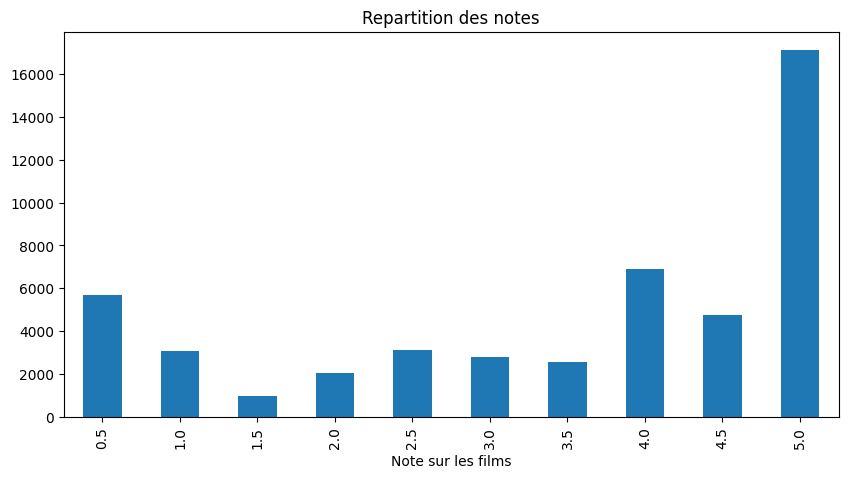

In [8]:
#Graphique montrant la répartition totale des notes

ax = df['note'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Repartition des notes',
          figsize=(10, 5))
ax.set_xlabel("Note sur les films")
plt.show()

In [9]:
df_sample=df.sample(500)

In [10]:
#on verifie on veut que ce soit équilibré
df_sample.note.value_counts()

,count
note,
5.0,171
4.0,71
0.5,68
4.5,47
1.0,34
3.5,31
3.0,30
2.5,22
2.0,19


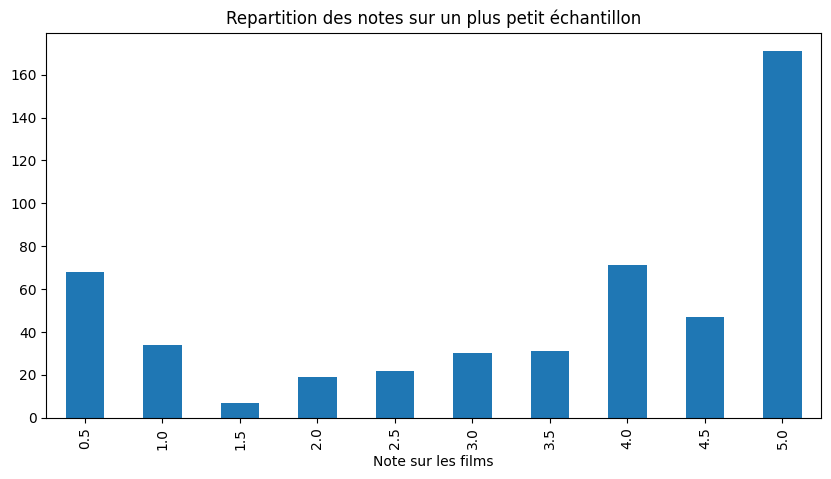

In [11]:
#Graphique qui montre la repartition des notes de l'echantillon (sample)

ax = df_sample['note'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Repartition des notes sur un plus petit échantillon',
          figsize=(10, 5))
ax.set_xlabel("Note sur les films")
plt.show()

### 1- Charger le modèle de Bert

In [12]:
model_class, tokenizer_c, weights_pretrained = (transf.DistilBertModel, transf.DistilBertTokenizer, 'distilbert-base-uncased')

tokenizer = tokenizer_c.from_pretrained(weights_pretrained)
model = model_class.from_pretrained(weights_pretrained)

### 2- Préparer le texte

In [13]:
exemple = df_sample.commentaire.head(5).values[3]
exemple

' y est suis maintenant fervent adorateur la troma the toxic avenger est south park avec vrais acteurs vrai nanar volontaire ne ennuie pas une seconde ai été subjugué par tant stupidité de connerie michael herz lloyd kaufmann ont quoi être fiers vivement les trois autres toxic '

In [14]:
print(tokenizer.encode(exemple,add_special_tokens=True))

[101, 1061, 9765, 24086, 2015, 2364, 6528, 4630, 10768, 2099, 15338, 4748, 6525, 2618, 3126, 2474, 19817, 9626, 1996, 11704, 24896, 2099, 9765, 2148, 2380, 13642, 2278, 27830, 15593, 2552, 26744, 27830, 4886, 17810, 2099, 5285, 12162, 14737, 11265, 4372, 11231, 2666, 14674, 16655, 2117, 2063, 9932, 3802, 2063, 4942, 9103, 9077, 11968, 9092, 2102, 5236, 4221, 2139, 17639, 2666, 2745, 2014, 2480, 6746, 23699, 2078, 2006, 2102, 22035, 2072, 3802, 2890, 10882, 2545, 6819, 3726, 3672, 4649, 25527, 8740, 19168, 11704, 102]


In [15]:
tokenizer.tokenize("a moving, if uneven, success")

['a', 'moving', ',', 'if', 'uneven', ',', 'success']

In [16]:
tokenized = df_sample['commentaire'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=128, truncation=True))

In [17]:
tokenized

,commentaire
653,"[101, 19804, 2229, 10861, 10927, 2483, 19817, ..."
30360,"[101, 2143, 21864, 9388, 16211, 14916, 8663, 7..."
37663,"[101, 29536, 2271, 13642, 2480, 6614, 9351, 81..."
14401,"[101, 1061, 9765, 24086, 2015, 2364, 6528, 463..."
17762,"[101, 14674, 5003, 2226, 3567, 2483, 10927, 24..."
...,...
16457,"[101, 14674, 4474, 23408, 5178, 3672, 7505, 20..."
48786,"[101, 3602, 9765, 14674, 14736, 2015, 29316, 3..."
48168,"[101, 27830, 4886, 2617, 20010, 15781, 15544, ..."
18062,"[101, 2143, 5136, 4886, 2102, 11968, 17935, 35..."


In [18]:
#pour voir la longueur max
max_len=0
for i in tokenized.values:
  if len(i)>max_len:
    max_len=len(i)

print(max_len)

128


In [19]:
tokenized_zeroes = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])
np.array(tokenized_zeroes).shape

(500, 128)

In [20]:
attention_mask = np.where(tokenized_zeroes != 0, 1, 0)
attention_mask.shape

(500, 128)

In [21]:
inputs_ids=torch.tensor(tokenized_zeroes)
attention_mask=torch.tensor(attention_mask)

In [22]:
inputs_ids

tensor([[  101, 19804,  2229,  ...,  4649,  5968,   102],
        [  101,  2143, 21864,  ...,  2666,  2143,   102],
        [  101, 29536,  2271,  ...,     0,     0,     0],
        ...,
        [  101, 27830,  4886,  ...,     0,     0,     0],
        [  101,  2143,  5136,  ...,  7110,  5332,   102],
        [  101,  1050,  9765,  ...,  6819,  3207,   102]])

In [23]:
with torch.no_grad():
  last_hidden_states = model(inputs_ids, attention_mask=attention_mask) #on recupere tout

In [25]:
features = last_hidden_states[0][:,0,:] #on filtre le dernier
features.shape

torch.Size([500, 768])

In [26]:
labels = df_sample["note"]

### 3- Model : Train/Test

In [27]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels)

In [36]:
print(train_labels[:10])
print(train_labels.dtype)

18062    4.0
27621    1.0
47060    5.0
27500    4.0
32957    4.0
24095    3.5
4457     3.5
40363    5.0
21853    4.0
11623    0.5
Name: note, dtype: float64
float64


In [37]:
#on doit les transformer en int :
train_labels = train_labels.astype(int)


In [38]:
from sklearn.ensemble import RandomForestClassifier

# On prend un autre modèle que celui vu dans le cours car notre modèle est multiclasse
lr_clf = RandomForestClassifier(n_estimators=100, random_state=42)
lr_clf.fit(train_features, train_labels)


RandomForestClassifier(random_state=42)

In [41]:
test_labels = test_labels.astype(int)

In [42]:
lr_clf.score(test_features,test_labels)

0.328

In [32]:
#Prediction
text = tokenizer.encode("it's a good product, but i don't like it", add_special_tokens=True)
tokenized_zeroes = np.array([text + [0]*(max_len-len(text))])
inputs_ids = torch.tensor(tokenized_zeroes)
attention_mask = torch.tensor(np.where(tokenized_zeroes != 0, 1, 0))

with torch.no_grad():
  pred_hidden_states = model(inputs_ids, attention_mask=attention_mask)
features = pred_hidden_states[0][:,0,:]

In [44]:
lr_clf.predict(features)

array([5])

In [43]:
lr_clf.predict_proba(features) #bon si ca depasse 70%

array([[0.15, 0.15, 0.09, 0.12, 0.17, 0.32]])